In [9]:
import os
import numpy as np
import scipy.io
import tensorflow as tf
#import tools
import matplotlib.pyplot as plt

GPU0 = '0'

In [10]:
def ttest_demo():
    ####### load sample data
    x_path = './Data_sample/P1_03001627_chair/test_25d_vox256/1c08f2aa305f124262e682c9809bff14_0_0_0.npz'
    y_true_path = './Data_sample/P1_03001627_chair/test_3d_vox256/1c08f2aa305f124262e682c9809bff14_0_0_0.npz'
    x_sample = tools.Data.load_single_voxel_grid(x_path, out_vox_res=64)
    y_true = tools.Data.load_single_voxel_grid(y_true_path, out_vox_res=256)

    ####### load model + testing
    model_path = './Model_released/'
    if not os.path.isfile(model_path + 'model.cptk.data-00000-of-00001'):
        print ('please download our released model first!')
        return

    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.visible_device_list = GPU0
    with tf.Session(config=config) as sess:
        saver = tf.train.import_meta_graph( model_path +'model.cptk.meta', clear_devices=True)
        saver.restore(sess, model_path+ 'model.cptk')
        print ('model restored!')

        X = tf.get_default_graph().get_tensor_by_name("Placeholder:0")
        Y_pred = tf.get_default_graph().get_tensor_by_name("aeu/Sigmoid:0")
        x_sample = x_sample.reshape(1, 64, 64, 64, 1)
        y_pred = sess.run(Y_pred, feed_dict={X: x_sample})

    ###### save result
    x_sample = x_sample.reshape(64, 64, 64)
    y_pred = y_pred.reshape(256, 256, 256)
    x_sample = x_sample.astype(np.int8)
    y_pred = y_pred.astype(np.float16)
    y_true = y_true.astype(np.int8)
    to_save = {'X_test': x_sample, 'Y_test_pred': y_pred, 'Y_test_true': y_true}
    scipy.io.savemat('demo_result.mat', to_save, do_compression=True)
    print ('results saved.')

def visualize():
    ######
    result_path = 'demo_result.mat'
    mat = scipy.io.loadmat(result_path)
    x_sample = mat['X_test']
    y_pred = mat['Y_test_pred']
    y_true = mat['Y_test_true']

    ######  if the GPU serve is able to visualize, otherwise comment the following lines
    th = 0.5
    y_pred[y_pred >= th] = 1
    y_pred[y_pred < th] = 0
    tools.Data.plotFromVoxels(x_sample, title='x_sample')
    tools.Data.plotFromVoxels(y_pred, title='y_pred')
    tools.Data.plotFromVoxels(y_true, title='y_true')
    from matplotlib.pyplot import show
    show()

In [1]:
    def plotFromVoxels(voxels,title=''):
        if len(voxels.shape)>3:
            x_d = voxels.shape[0]
            y_d = voxels.shape[1]
            z_d = voxels.shape[2]
            v = voxels[:,:,:,0]
            v = np.reshape(v,(x_d,y_d,z_d))
        else:
            v = voxels
        x, y, z = v.nonzero()
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x, y, z, zdir='z', c='red')
        #plt.show()
        plt.title(title)
        from matplotlib.pyplot import show
        show(block=False)

In [4]:
def load_single_voxel_grid(path, out_vox_res=256):
        with np.load(path) as da:
            voxel_grid = da['arr_0']
        if len(voxel_grid)<=0:
            print (" load_single_voxel_grid error: ", path)
            exit()

        #Data.plotFromVoxels(voxel_grid)
        voxel_grid = voxel_grid_padding(voxel_grid)

        ## downsample
        if out_vox_res < 256:
            voxel_grid = vox_down_single(voxel_grid, to_res=out_vox_res)
        return voxel_grid

In [5]:
def voxel_grid_padding(a):
        x_d = a.shape[0]
        y_d = a.shape[1]
        z_d = a.shape[2]
        channel = a.shape[3]
        ori_vox_res = 256
        size = [ori_vox_res, ori_vox_res, ori_vox_res,channel]
        b = np.zeros(size,dtype=np.float32)

        bx_s = 0;bx_e = size[0];by_s = 0;by_e = size[1];bz_s = 0; bz_e = size[2]
        ax_s = 0;ax_e = x_d;ay_s = 0;ay_e = y_d;az_s = 0;az_e = z_d
        if x_d > size[0]:
            ax_s = int((x_d - size[0]) / 2)
            ax_e = int((x_d - size[0]) / 2) + size[0]
        else:
            bx_s = int((size[0] - x_d) / 2)
            bx_e = int((size[0] - x_d) / 2) + x_d

        if y_d > size[1]:
            ay_s = int((y_d - size[1]) / 2)
            ay_e = int((y_d - size[1]) / 2) + size[1]
        else:
            by_s = int((size[1] - y_d) / 2)
            by_e = int((size[1] - y_d) / 2) + y_d

        if z_d > size[2]:
            az_s = int((z_d - size[2]) / 2)
            az_e = int((z_d - size[2]) / 2) + size[2]
        else:
            bz_s = int((size[2] - z_d) / 2)
            bz_e = int((size[2] - z_d) / 2) + z_d
        b[bx_s:bx_e, by_s:by_e, bz_s:bz_e,:] = a[ax_s:ax_e, ay_s:ay_e, az_s:az_e, :]

        #Data.plotFromVoxels(b)
        return b

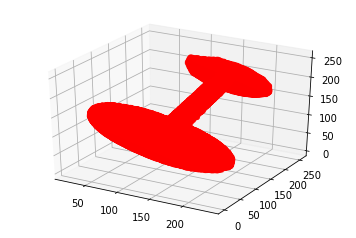

In [11]:
a=load_single_voxel_grid('./Real_table/test_3d_vox256/02_1539.npz')
plotFromVoxels(a)